In [1]:
import copy
import numpy as np
import sys

In [2]:
import analysis_config

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm

In [4]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

ModuleNotFoundError: No module named 'linefinder'

In [5]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

ModuleNotFoundError: No module named 'galaxy_dive'

In [6]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

# Load Data

In [7]:
default_sim = 'm12i'
default_snum = 465

In [8]:
sim_name, snum = exec_helpers.choose_config_or_commandline(
    [ default_sim, default_snum ]
)
print( 'Using sim {}, snum {}'.format( sim_name, snum ) )

Using sim m12i, snum 465


In [9]:
galdef = ''

In [10]:
file_manager = file_management.FileManager( 'CGM_fate' )

In [11]:
defaults = file_manager.get_linefinder_analysis_defaults(
    '_CGM_snum{}'.format( snum ),
    sim_name = sim_name,
    galdef = galdef
)

In [12]:
ind = defaults['ahf_index'] - snum

In [13]:
w = a_worldlines.Worldlines( **defaults )

In [14]:
w.retrieve_halo_data()

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [15]:
print( w.tag )

m12i_CGM_snum465


In [16]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{12} M_\odot$, z=0.25


In [17]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [18]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

In [19]:
g_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_GAS,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],
)

In [20]:
g_plotter = generic_plotter.GenericPlotter(
    g_data,
    label=plot_label,
)

In [21]:
s_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],    
)

In [22]:
s_plotter = generic_plotter.GenericPlotter( s_data )

### Create a circle to plot

In [23]:
r_gal = w.r_gal[ind]

In [24]:
circle = []
for phi in np.linspace( 0., 2.*np.pi, 256 ):
    
    circle.append(
        [ r_gal*np.cos(phi), r_gal*np.sin(phi), 0. ]
    )
    
circle = np.array( circle )

rotated_circle = data_operations.align_axes( circle, s_data.total_ang_momentum, )

# Illustrative Plot

In [25]:
r_vir = w.r_vir.values[ind]

In [26]:
t_show_min = {
    465 : 0.5,
    172 : 0.25,
    214 : 0.25,
}
t_show_max = {
    465 : 1.0,
    172 : 0.5,
    214 : 0.5,
}

In [27]:
data_args = {
    465 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    172 : { 'smooth_data' : True, 'smoothing_window_length' : 11 },
    214 : { 'smooth_data' : True, 'smoothing_window_length' : 21 },
}

# Plot vs Time

In [28]:
w.data_masker.clear_masks()

In [29]:
# Set limits
y_max = np.nanpercentile( w.get_selected_data_over_time(
    data_key = 'R',
    snum = snum,
    classification = 'is_CGM_IGM_accretion',
)[:,0], 80. )*1.1
y_max = w.r_vir.values[0]*1.5

# Plot for Next Fate

In [30]:
used_classification_list = copy.copy( classification_list )
used_classification_list.remove( 'is_CGM_halo_transfer' )

In [31]:
# Don't plot CGM accreted-satellite for m10s at low-z when applying the time cut, because there are just
# too few particles
if (config.MASS_BINS[sim_name] == 'm10'):
    used_classification_list.remove( 'is_CGM_accreted_to_satellite' )
# Don't plot CGM still for m12s at high-z, because there are just
# too few particles
if (
    snum < 465 and
    config.MASS_BINS[sim_name] == 'm12'
):
    used_classification_list.remove( 'is_CGM_still' )

In [ ]:
used_cl

# Cooling Flow Investigation

In [32]:
w.data_masker.clear_masks( True )

In [33]:
w.data_masker.mask_data( 'PType', data_value=0 )

In [34]:
r_rvir = w.get_processed_data(
    'R',
    scale_key = 'Rvir',
    scale_a_power = 1.,
    scale_h_power = -1.,
)
in_region_at_ind = {
    465: np.logical_and( ( 0.2 < r_rvir[:,ind] ), ( r_rvir[:,ind] < 0.3 ) ),
    172: np.logical_and( ( 0.4 < r_rvir[:,ind] ), ( r_rvir[:,ind] < 0.5 ) ),
}

in_region_at_ind_tiled = np.tile( in_region_at_ind[snum], ( w.n_snaps, 1 ) ).transpose()
w.data_masker.mask_data( 'in_region', custom_mask=np.invert( in_region_at_ind_tiled ) )

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [35]:
import matplotlib.cm as cm
import matplotlib.colors as plt_colors

In [36]:
import galaxy_dive.plot_data.pu_colormaps as pu_cm  

In [37]:
t = w.get_data( 'time' )

In [38]:
x_min = t[ind]
x_maxes = {
    465: 12.5,
    172: 5,
}
x_max = x_maxes[snum]
x_range = [ x_min, x_max ]

In [39]:
w.data_masker.mask_data( 'time', x_min, x_max, tile_data=True )

In [40]:
n_snaps = ( ( t > x_min ) & ( t < x_max ) ).sum()

In [41]:
w.calc_phi( s_data.total_ang_momentum )

In [42]:
ts = w.get_data('time')
Rs = w.data_masker.get_selected_data_over_time('R',snum=465)
Ts = w.data_masker.get_selected_data_over_time('T',snum=465)
Ms = w.data_masker.get_selected_data_over_time('M',snum=465)
Phis = w.data_masker.get_selected_data_over_time('Phi',snum=465)

In [43]:
tmin = 10.8; tmax = 13.
t_inds = ((ts > tmin)*(ts<tmax)).nonzero()[0]

In [59]:
t_fracs = (new_ts-tmin)/(tmax-tmin)
oversample = lambda y,dt,tmin=tmin,tmax=tmax,ts=ts[t_inds]: np.interp(np.arange(tmin,tmax,dt),ts[::-1],y[::-1])

In [ ]:
#Ls = w.data_masker.get_selected_data_over_time('Lmag',snum=465)

In [46]:
import numpy as np
import pylab as pl
import pdb
from numpy import log10 as log
cmap = matplotlib.cm.viridis

In [47]:
inds = np.random.randint(Rs.shape[0],size=20)
fig = pl.figure(figsize=(12,5))
for ind in inds:
    pl.scatter(new_ts, oversample(Rs[ind,t_inds]),c=cmap(t_fracs),s=1)
pl.ylim(0,100)
pl.xlabel(r'time [Gyr]')
pl.ylabel(r'radius [kpc]')
pl.savefig('../figures/r_vs_t.pdf',bbox_inches='tight')

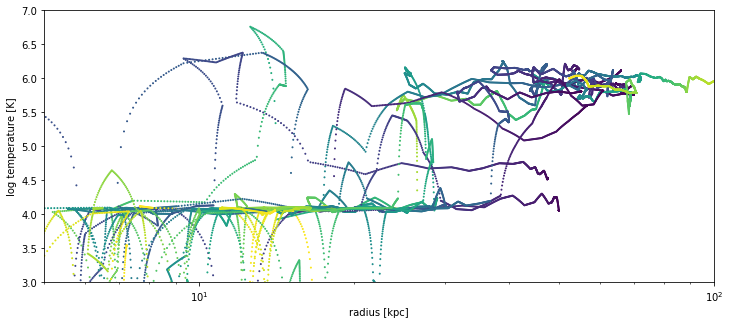

In [48]:
inds = np.random.randint(Rs.shape[0],size=10)
fig = pl.figure(figsize=(12,5))
for ind in inds:
    pl.scatter(oversample(Rs[ind,t_inds]),log(oversample(Ts[ind,t_inds])),c=cmap(t_fracs),s=1)
pl.ylim(3,7)
pl.xlim(5,100)
pl.semilogx()
pl.ylabel(r'log temperature [K]')
pl.xlabel(r'radius [kpc]')
pl.savefig('../figures/T_vs_r.pdf',bbox_inches='tight')
fig

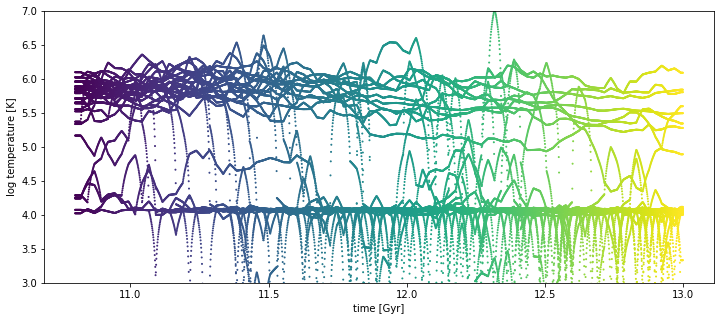

In [67]:
inds = np.random.randint(Rs.shape[0],size=30)
fig = pl.figure(figsize=(12,5))
new_ts = np.arange(tmin,tmax,0.001)
t_fracs = (new_ts-tmin)/(tmax-tmin)
for ind in inds:
    pl.scatter(new_ts,log(oversample(Ts[ind,t_inds],dt=0.001)),c=cmap(t_fracs),s=1)
pl.ylim(3,7)
# pl.xlim(5,100)
# pl.semilogx()
pl.ylabel(r'log temperature [K]')
pl.xlabel(r'time [Gyr]')
pl.savefig('../figures/T_vs_t.pdf',bbox_inches='tight')
fig

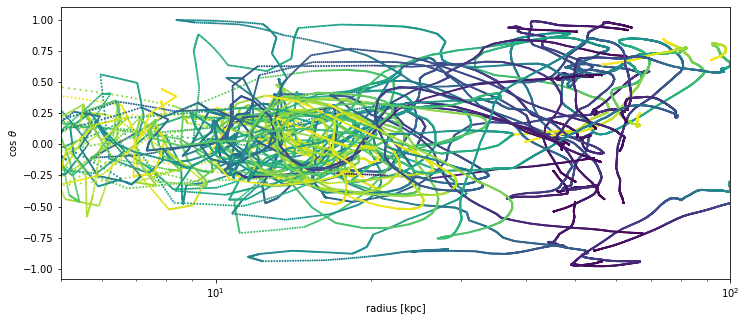

In [49]:
inds = np.random.randint(Rs.shape[0],size=30)
fig = pl.figure(figsize=(12,5))
for ind in inds:
    pl.scatter(oversample(Rs[ind,t_inds]),np.cos(oversample(Phis[ind,t_inds])/180.*np.pi),c=cmap(t_fracs),s=1)
# pl.ylim(3,7)
pl.xlim(5,100)
pl.semilogx()
pl.ylabel(r'cos $\theta$')
pl.xlabel(r'radius [kpc]')
pl.savefig('../figures/theta_vs_r.pdf',bbox_inches='tight')
fig

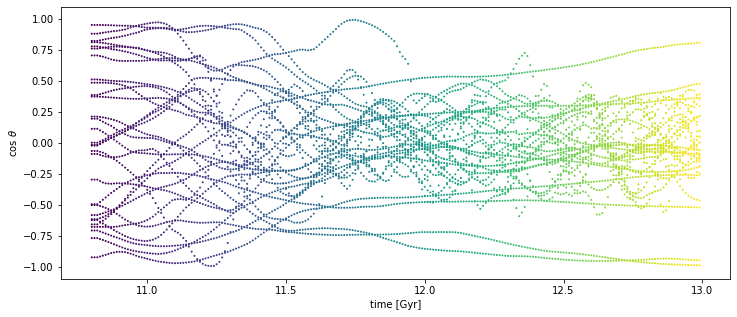

In [68]:
inds = np.random.randint(Rs.shape[0],size=30)
fig = pl.figure(figsize=(12,5))
new_ts = np.arange(tmin,tmax,0.01)
t_fracs = (new_ts-tmin)/(tmax-tmin)
for ind in inds:
    pl.scatter(new_ts,np.cos(oversample(Phis[ind,t_inds],dt=0.01)/180.*np.pi),c=cmap(t_fracs),s=1)
# pl.ylim(3,7)
# pl.xlim(5,100)
# pl.semilogx()
pl.ylabel(r'cos $\theta$')
pl.xlabel(r'time [Gyr]')
pl.savefig('../figures/theta_vs_t.pdf',bbox_inches='tight')
fig

In [110]:
pl.close('all')

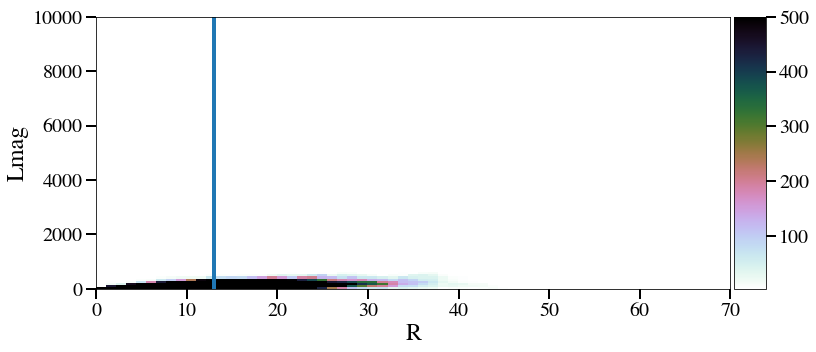

In [55]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

y_data = w.get_selected_data( 'Lmag' ) / w.get_selected_data( 'M' )

w_plotter.histogram2d(
    'R',
    'Lmag',
    y_data = y_data,
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=500 ),
#     y_scale = 'log',
    y_range = [ 0, 10000 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
    cmap = cm.cubehelix_r,
)

ax.axvline(
    13,
    linewidth = 4,
)

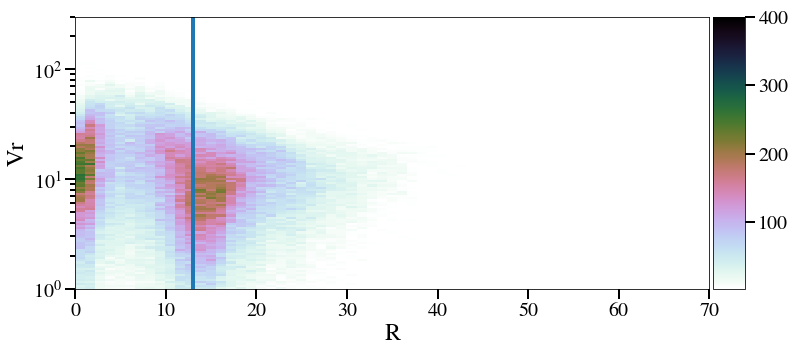

In [56]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'Vr',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
    y_scale = 'log',
    y_range = [ 1., 300 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
    cmap = cm.cubehelix_r,
)

ax.axvline(
    13,
    linewidth = 4,
)

TypeError: get_data() got an unexpected keyword argument 'weight_data'

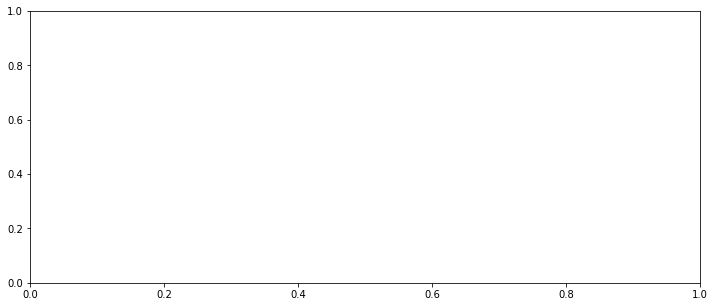

In [122]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w.calc_phi( s_data.total_ang_momentum )

w_plotter.histogram2d(
    'time',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
#     y_scale = 'log',
#     y_range = [ 1e3, 1e7 ],
    x_range = x_range,
    n_bins_x = n_snaps + 1,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

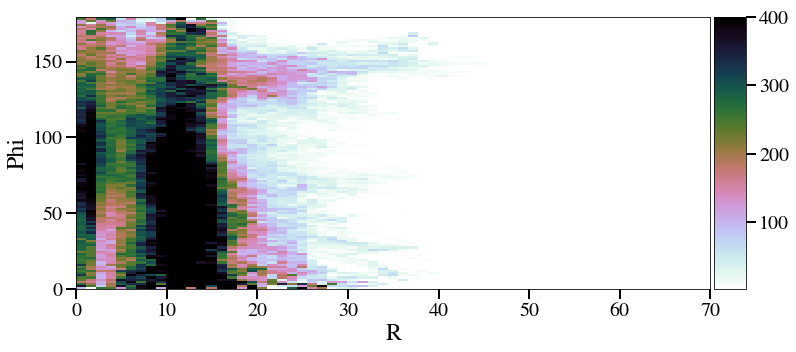

In [58]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w.calc_phi( s_data.total_ang_momentum )

w_plotter.histogram2d(
    'R',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
#     y_scale = 'log',
#     y_range = [ 1e3, 1e7 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)